In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean, stdev
from scipy import stats, spatial
import antropy as ant
from ptflops import get_model_complexity_info

from main.layout import Layout
from main.models import Deeplab_ASPP_Layout
from main.auto_models import MTSeqBackbone, MTSeqModel
from main.algorithms import enum_layout, remove_redundancy, enum_layout_wo_rdt, metric_inference, init_S, coarse_to_fined

In [2]:
# Enum all layouts for given T (3 for NYUv2) and B (5 for coarse Deeplab_Resnet34)
data = 'NYUv2'
model = 'resnet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 
coarse = True

In [2]:
# Enum all layouts for given T (3 for NYUv2) and B (9 for coarse MobileNetv2)
data = 'NYUv2'
model = 'mobilenet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 # 9 - coarse v1/v4 with init weights, 6 - coarse v2, 5 - coase v3/v5 with init weights, 8 - shorter net
coarse = True

In [2]:
# Enum all layouts for given T (5 for Taskonomy) and B (5 for coarse Deeplab_Resnet34)
data = 'Taskonomy'
model = 'resnet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [2]:
# Enum all layouts for given T (5 for Taskonomy)  and B (5 for coarse MobileNetv2)
data = 'Taskonomy'
model = 'mobilenet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [3]:
layout_list = [] 
S0 = init_S(T, B) # initial state
L = Layout(T, B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
len(layout_list)

51

In [4]:
est_metric = 'val_acc'
real_metric = 'val_acc'
est_date = '0414'
real_date = '0227'

# Load 2-Task

In [5]:
two_task_pd = pd.read_excel('./2task/' + data + '_2task_metrics_' + model + '_' + est_date + '_' + est_metric +'.xlsx',engine='openpyxl',index_col=0)

In [6]:
two_task_pd

,"(0, 2)-0","(0, 2)-1","(1, 2)-0","(1, 2)-1","(0, 1)-0","(0, 1)-1"
branch,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.442673,6.237714,-5.095600,0.216031,0.892363,-0.797522
2,-0.449635,10.725936,-3.565047,1.677439,-3.231289,-0.980604
3,-2.614659,9.325515,-4.183829,-0.646166,1.534438,1.619393
4,-1.561908,12.311573,-4.203497,1.125333,2.031803,2.090345
5,0.115544,13.679681,-3.958563,2.266160,0.220317,1.548020


In [7]:
tasks = [i for i in range(T)]
two_task_metrics = {}
for two_set in itertools.combinations(tasks, 2):
    two_task_metrics[two_set] = []
    for b in range(0, B+1): 
        metric1 = two_task_pd[str(two_set)+'-0'][b]
        metric2 = two_task_pd[str(two_set)+'-1'][b]
        two_task_metrics[two_set].append([metric1, metric2])

In [278]:
fluc = {}
for t in tasks:
    fluc[t] = []
    
for two_set in itertools.combinations(tasks, 2):
    print(two_set)
    for idx in range(2):
        metric = two_task_pd[str(two_set)+'-'+str(idx)].tolist()[1:]
        new_metric = [v*1 for v in metric]
#         random.shuffle(new_metric)
#         print(metric)
        print(new_metric)
        vol = ant.svd_entropy(new_metric, normalize=True)
#         vol = ant.perm_entropy(new_metric, normalize=True)
#         vol = ant.spectral_entropy(new_metric, sf=100, method='welch', normalize=True)
#         vol = ant.sample_entropy(np.array(new_metric).T)
        print(vol)
        fluc[two_set[idx]].append(vol)
        print('='*60)
        
score_weights = []
for key in fluc:
    score_weights.append(1-mean(fluc[key]))
score_weights_norm = [float(i)/sum(score_weights) for i in score_weights]
print(score_weights_norm)

(0, 1)
[0.8923629510104724, -3.231288958398469, 1.534437590691335, 2.031803004274584, 0.2203168421002072]
0.9409924832822225
[-0.7975218004391482, -0.9806038788753166, 1.619392640852904, 2.090345127078263, 1.548019727233237]
0.9129135651893913
(0, 2)
[1.442672840857072, -0.4496353153987318, -2.614658782814494, -1.561907765533737, 0.1155436860866886]
0.852161501611141
[6.237713920085937, 10.72593590831177, 9.325514768816099, 12.31157269386283, 13.67968074901596]
0.36216079271071366
(1, 2)
[-5.095599872475469, -3.565047249903736, -4.183829135233585, -4.203496575979625, -3.958563392797991]
0.3435138123641793
[0.216031353698741, 1.677438630855375, -0.6461661024501701, 1.125332683855535, 2.266160277058439]
0.9755053684455606
[0.1282565168145154, 0.4610581185450838, 0.41068536464040084]


# Est. Results for Layouts

In [9]:
# Run for all L
for L in layout_list:
    print(L)
    metric_inference(L, two_task_metrics)
#     L.set_score()
    L.set_score_weighted(score_weights_norm)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
[[0, 1, 5], [0, 2, 5]]
[[1, 0, 5], [1, 2, 5]]
[[2, 0, 5], [2, 1, 5]]
[0.16793026409344788, -1.205271832782377, 7.9729205130372]
2.740199555327954
[[{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 5]]
[[2, 0, 0], [2, 1, 5]]
[0.0, -1.9792816963989954, 1.1330801385292195]
-0.44722446515377406
[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 0]]
[[2, 0, 0], [2, 1, 0]]
[0.0, 0.0, 0.0]
0.0
[[{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 1]]
[[2, 0, 0], [2, 1, 1]]
[0.0, -2.5477999362377344, 0.1080156768493705]
-1.1303233873972907
[[{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0]]
[[1, 0, 0], [1, 2, 2]]
[[2, 0, 0], [2, 1, 2]]
[0.0, -1.782523624951868, 0.8

# Filter Layouts by Metric +  Sort Layout by Flops

In [10]:
# Compute flops for good layouts
for L in layout_list:
    if min(L.metric_list) > -0.2 and L.score > 0.:
        print(L)
        with torch.cuda.device(0):
            if coarse == True:
                fined_B = 17
                mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16]}
                layout = coarse_to_fined(L, fined_B, mapping)
            else:
                layout = L
            model = Deeplab_ASPP_Layout(layout)
            macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                   print_per_layer_stat=False, verbose=False)
            print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
            print('='*80)
            L.flops = float(macs.split(' ')[0])
    else:
        L.flops = -1.

[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
Computational complexity:       37.1 GMac
[[{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}]]
Computational complexity:       55.53 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}]]


KeyboardInterrupt: 

In [9]:
# sort by flops - defined in layout class
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k].flops,reverse=False)

In [10]:
step = 1
for i in range(0,len(layout_order),step):
    L = layout_list[layout_order[i]]
    if (L.flops) > 0:
        print(layout_order[i])
        print(L)
        print(L.score)
        print('=' * 100)

49
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}]]
2.0149434140606632
40
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.7787641846698006
43
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.883304959354685
30
[[{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.3032957316380727
34
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.774328805682
7
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.0427822046298196
46
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}]]
2.471050023929214
36
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}]]
2.1543500099399617
39
[[{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.6792098455843438
29
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.9849800425548723
16
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}],

# Sort Layout by Score (fine/coarse)

In [11]:
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=True)

In [12]:
# choose some layouts to verify
step = 1
for i in range(0,len(layout_order),step):
    print(layout_order[i])
    L = layout_list[layout_order[i]]
    print(L)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

7
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
[0.0577718430433443, 0.0, 6.83984037450798]
2.81643195364564
0
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
[0.16793026409344788, -1.205271832782377, 7.9729205130372]
2.740199555327954
49
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}]]
[1.0736733451806362, -1.056575724450681, 7.402506716435747]
2.690663957926249
47
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}]]
[0.2349476193704234, -0.9341091328598639, 7.288866485460635]
2.5928857543787625
11
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}]]
[-0.7809538827668685, 0.0, 6.155786346931415]
2.427928935741479
39
[[{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
[0.791083844437926, -0.7373510614127363, 6.201687269583573]
2.3084421630083294
48
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0}, {2}, {1}]]
[0.2349476193704234, -1.056575724450681, 6

### for coarser branching points

In [20]:
def valid_layout(L, valid_b):
    # Main Function:
    ## Figure out the subtrees consisting the given layout
    valid = True
    
    S = L.state
    for t1 in range(L.T):
        for t2 in range(L.T):
            if t1 == t2:
                continue
            
            branch = L.B # No branch - All share
            for i in range(L.B): # For each block
                share_flag = False
                for task_set in S[i]: # For each task set in ith block
                    # There exists a task set has both t1 and t2 -> t1 and t2 share in ith block
                    if t1 in task_set and t2 in task_set: 
                        share_flag = True
                        break
                if share_flag is False:
                    branch = i
                    break
            if branch not in valid_b:
                valid = False
    return valid

In [21]:
# choose layouts within valid branching points (coarse version)
valid_b = [1,4,8,14,17]
layout_idx = 0
for L in layout_list:
    if valid_layout(L, valid_b):
        print(layout_idx)
        print(L)
        print(L.score)
        print('=' * 100)
    layout_idx += 1

0
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
1.5806222710710416
55
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
-0.06087626941943092
56
[[{0, 1, 2}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
0.0065458896499245856
59
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}

In [24]:
layout_list[2]

[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]

# SROCC/cosine-smilarity between real and est.

In [13]:
def load_obj(name):
    with open('./ntask/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [18]:
# Extract real results from layouts' logs
real_log = load_obj('real_results_'+data+'_'+model+'_' + real_date)
idx = real_log['layout']
real_results = real_log[real_metric]

# real = np.mean(real_results[:], axis=1)
real = np.dot(real_results, score_weights_norm) 
real_sub1 = real_results[:,0]
real_sub2 = real_results[:,1]
real_sub3 = real_results[:,2]

if data == 'Taskonomy':
    real_sub4 = real_results[:,3]
    real_sub5 = real_results[:,4]

In [19]:
# Extract est. results
est = [layout_list[i].score for i in idx]
est_sub1 = [layout_list[i].metric_list[0] for i in idx]
est_sub2 = [layout_list[i].metric_list[1] for i in idx]
est_sub3 = [layout_list[i].metric_list[2] for i in idx]

if data == 'Taskonomy':
    est_sub4 = [layout_list[i].metric_list[3] for i in idx]
    est_sub5 = [layout_list[i].metric_list[4] for i in idx]

### total 

In [20]:
stats.spearmanr(est,real)

SpearmanrResult(correlation=0.8721804511278194, pvalue=5.3897404423302e-07)

In [15]:
1 - spatial.distance.cosine(est, real)

0.8116349423893666

In [16]:
np.corrcoef(est,real)

array([[1.        , 0.24374745],
       [0.24374745, 1.        ]])

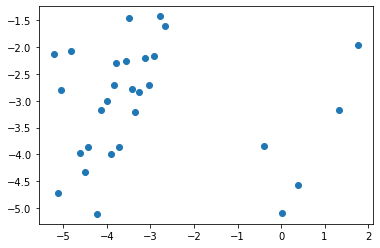

In [19]:
plt.scatter(est,real)

### task 1

In [21]:
stats.spearmanr(est_sub1,real_sub1)

SpearmanrResult(correlation=0.19879540616780247, pvalue=0.4007798676618556)

In [19]:
1 - spatial.distance.cosine(est_sub1,real_sub1)

0.0403516482952857

In [20]:
np.corrcoef(est_sub1,real_sub1)

array([[1.        , 0.02294597],
       [0.02294597, 1.        ]])

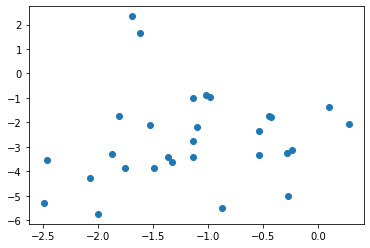

In [22]:
plt.scatter(est_sub1,real_sub1)

### task 2

In [22]:
stats.spearmanr(est_sub2,real_sub2)

SpearmanrResult(correlation=0.34332273079609676, pvalue=0.13833927207711622)

In [24]:
1 - spatial.distance.cosine(est_sub2,real_sub2)

0.6905724290271665

In [25]:
np.corrcoef(est_sub2,real_sub2)

array([[1.        , 0.67145035],
       [0.67145035, 1.        ]])

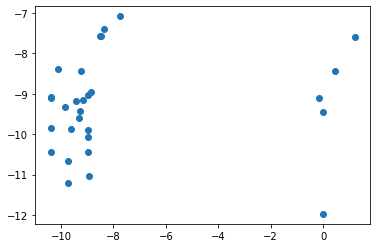

In [23]:
plt.scatter(est_sub2,real_sub2)

### task 3

In [23]:
stats.spearmanr(est_sub3,real_sub3)

SpearmanrResult(correlation=0.912242672290638, pvalue=2.124799261049569e-08)

In [28]:
1 - spatial.distance.cosine(est_sub3,real_sub3)

0.9582296238510127

In [29]:
np.corrcoef(est_sub3,real_sub3)

array([[1.        , 0.77240937],
       [0.77240937, 1.        ]])

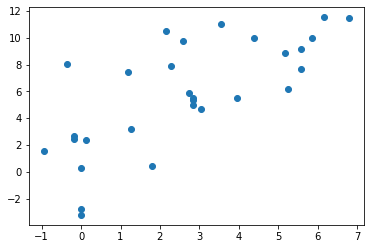

In [24]:
plt.scatter(est_sub3,real_sub3)

# task 4 & 5

In [18]:
stats.spearmanr(est_sub4,real_sub4)

SpearmanrResult(correlation=0.5563585927447606, pvalue=0.0754917746708913)

In [19]:
stats.spearmanr(est_sub5,real_sub5)

SpearmanrResult(correlation=0.7727272727272727, pvalue=0.005299487178643863)

# Flops of Top5

In [10]:
# layout_idx = [45,0,50,37,49,2,9] # NYUv2 resnet top-5
# layout_idx = [7,11,10,9,8,0,2] # NYUv2 mobilenet top-5
# layout_idx = [353,352,958,480,360,1037,962,1046,943,1063,479,817,562,4697,6539,1,0,4] # Taskonomy resnet top-5
# layout_idx = [651,2947,3221,3215,3220,3261,0,4] # Taskonomy mobilenet top-5
layout_idx = [7]

In [6]:
if model == 'resnet':
    prototxt = 'models/deeplab_resnet34_adashare.prototxt'
    coarse_B = 5
    mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16], 5:[17]}
elif model == 'mobilenet':
    prototxt = 'models/mobilenetv2.prototxt'
#     coarse_B = 9
#     mapping = {0:[0], 1:[1,2], 2:[3,4,5,6], 3:[7,8,9,10,11], 4:[12,13,14,15,16,17], 5:[18,19,20,21,22], 
#            6:[23,24,25,26,27], 7:[28,29,30], 8:[31], 9:[32]} 
#     coarse_B = 6
#     mapping = {0:[0], 1:[1,2,3,4,5,6], 2:[7,8,9,10,11], 3:[12,13,14,15,16,17], 4:[18,19,20,21,22,23,24,25,26,27], 5:[28,29,30,31], 6:[32]}
    coarse_B = 5
    mapping = {0:[0,1,2,3,4,5,6], 1:[7,8,9,10,11,12,13,14,15,16,17], 2:[18,19,20,21,22], 
           3:[23,24,25,26,27,28,29,30], 4:[31], 5:[32]}

In [7]:
if data == 'NYUv2':
    cls_num = {'segment_semantic': 40, 'normal':3, 'depth_zbuffer': 1}
    input_dim = (3,321,321)
elif data == 'Taskonomy':
    cls_num = {'segment_semantic': 17, 'normal': 3, 'depth_zbuffer': 1, 'keypoints2d': 1, 'edge_texture': 1}
    input_dim = (3,224,224)

In [8]:
with torch.no_grad():
    backbone = MTSeqBackbone(prototxt)
    fined_B = len(backbone.basic_blocks)
    feature_dim = backbone(torch.rand((1,)+input_dim)).shape[1]

In [11]:
for idx in layout_idx:
    layout = coarse_to_fined(layout_list[idx], fined_B, mapping)
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=layout, feature_dim=feature_dim, cls_num=cls_num, verbose=False)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
        print('Layout idx: '+str(idx))
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Parameters: ', params))
        print('='*80)
        break

Layout idx: 7
Computational complexity:       20.11 GMac
Parameters:                     158.79 M


## top-k under flops

In [16]:
K = 5
flops = 171.39 # Taskonomy, resnet
count = 0
for i in range(0,len(layout_order)):
    if count >= K:
        break
    L = coarse_to_fined(layout_list[layout_order[i]], fined_B, mapping)
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=L, feature_dim=feature_dim, cls_num=cls_num, verbose=False)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
    if float(macs[:-5]) <= flops:
        print(layout_order[i])
        print(layout_list[layout_order[i]])
        print(layout_list[layout_order[i]].score)
        print(macs)
        print('=' * 100)
        
        count += 1

958
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}], [{0, 3}, {4}, {2}, {1}]]
2.1406691092673733
169.47 GMac
480
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3}, {2, 4}, {1}], [{0}, {3}, {2, 4}, {1}]]
2.1089931778379
168.75 GMac
360
[[{1, 2, 3, 4}, {0}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {2}, {1}], [{0}, {3, 4}, {2}, {1}]]
2.045923858933043
169.47 GMac
1037
[[{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{0, 3}, {2, 4}, {1}]]
1.9554496973706585
151.03 GMac
962
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}]]
1.8953368092111829
163.73 GMac
